In [1]:
# Imports
from scipy import sparse
import scipy
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import time
from numpy import linalg as LA

# Frank-Wolfe - standard algorithm

In [47]:
# FW objective function
def FW_objective_function(diff_vec):
    return 0.5*(np.power(diff_vec,2).sum())

# Regular FW algorithm
def FrankWolfe(X, objective_function, delta, empties = 0, printing_res = True, Z_init = None, max_iter = 150, patience = 1e-3):
    '''
    :param X: sparse matrix with ratings and 'empty values', rows - users, columns - books.
    :param objective_function: objective function that we would like to minimize with FW
    :param delta: Radius of the feasible's set ball
    :param empties (optional): Empty values of X are zeros (0) or NaN ('nan'). Default = 0
    :param Z_init (optional): In case we want to initialize Z with a known matrix, if not given Z_init will be a zeros matrix. Default = None.
    :param max_iter (optional): max number of iterations for the method. Default = 150.
    :param patience (optional): once reached this tolerance provide the result. Default = 1e-3.
    :return: Z: matrix of predicted ratings - it should be like X but with no 'empty values'
    :return: accuracy: difference between original values (X) and predicted ones (Z)
    '''

    # Get X indexes for not empty values
    if empties == 0:
        idx_ratings = np.argwhere(X != 0)
    elif empties == 'nan':
        idx_ratings = np.argwhere(~np.isnan(X))
    else:
        return print('Error: Empties argument', empties, 'not valid.')

    idx_rows = idx_ratings[:,0]
    idx_cols = idx_ratings[:,1]

    # Initialize Z
    if Z_init == 'random uniform':
        Z = np.random.uniform(low = 0.01, high = 1, size = X.shape)
    elif Z_init is not None:
        Z = Z_init
    else:
        Z = np.zeros(X.shape)

    # Create vectors with the not empty features of the sparse matrix
    X_rated = X[idx_rows, idx_cols]
    Z_rated = Z[idx_rows, idx_cols]
    diff_vec = np.array(Z_rated - X_rated)[0]

    # Create needed variables
    diff_loss = patience + 1
    loss = objective_function(diff_vec)
    res_list = [loss]
    it = 0
    while (diff_loss > patience) and (it < max_iter):

        # Gradient
        grad = sparse.csr_matrix((diff_vec, (idx_rows, idx_cols)))

        # SVD - Compute k = 1 singular values and its vectors, starting from the largest (which = 'LM')
        u_max, s_max, v_max = sparse.linalg.svds(grad, k = 1, which='LM')   #

        # Update
        Zk_tilde = -delta*np.outer(u_max,v_max)

        alpha_k = 2/(it+2) #alpha - as studied in class
        Z = (1-alpha_k)*Z + alpha_k*Zk_tilde

        # Loss
        diff_vec = np.array(Z[idx_rows, idx_cols] - X_rated)[0]
        new_loss = objective_function(diff_vec)

        # Improvement at this iteration
        diff_loss = np.abs(loss - new_loss)
        loss = new_loss

        if printing_res == True:
            if it == 1 or it % 50 == 0:
                print('Iteration:', it, 'Loss:', loss, 'Loss diff:', diff_loss, 'Rank(Z): ', np.linalg.matrix_rank(Z))

        # Count iteration
        it += 1

        res_list.append(loss)
        
    return Z, loss, res_list

# Frank-Wolfe In-face

In [48]:
#time_out = time.process_time() + 5

In [76]:
# Binary search for alpha stop
def alpha_binary_search(Zk, Dk, delta, max_value = 1, min_value = 0, tol = 0.05, time_out = 5):

    #Inizialization

    best_alpha = (max_value - min_value) / 2

    testing_matrix = Zk + best_alpha * Dk

    sentinel = False

    while time.process_time() <= time_out:

      testing_mat_nuclear_norm = LA.norm(testing_matrix, ord = 'nuc')

      sentinel = True

    #Binary Search

    if sentinel == True:

      while testing_mat_nuclear_norm <= delta and (max_value - min_value) >= tol and time.process_time() <= time_out:

          min_value = best_alpha

          best_alpha = (max_value - min_value) / 2

          testing_matrix = Zk + best_alpha * Dk

          testing_mat_nuclear_norm = LA.norm(testing_matrix, ord = 'nuc')

    return best_alpha

In [225]:
# Binary search for alpha stop
def alpha_binary_search(Zk, Dk, delta, max_value = 1, min_value = 0, tol = 1e-3):

    #Inizialization

    best_alpha = (max_value - min_value) / 2

    testing_matrix = Zk + best_alpha * Dk

    testing_mat_nuclear_norm = LA.norm(testing_matrix, ord = 'nuc')
    print('nuc norm:', testing_mat_nuclear_norm, 'alpha', best_alpha)
    #Binary Search
    it_alph = 0
    diff_it = tol +1

    while diff_it >= tol: #and time.process_time() <= time_out:
        #print ('alpha it', it_alph, 'alph', best_alpha)
        print(it_alph, 'nuc norm:', testing_mat_nuclear_norm, 'alpha', best_alpha)
        if testing_mat_nuclear_norm <= delta:
            min_value = best_alpha
            best_alpha = best_alpha + (max_value - min_value) / 2
        else:
            best_alpha = (best_alpha + min_value) / 2

        testing_matrix = Zk + best_alpha * Dk

        testing_mat_nuclear_norm = LA.norm(testing_matrix, ord = 'nuc')

        diff_it = np.abs(best_alpha - min_value)
        it_alph += 1

        it_alph += 1

    return best_alpha

In [208]:
# Binary search for alpha stop
def beta_line_search(objective_func, Zk, Dk, idxs, X_rated, max_value = 1, min_value = 0, tol = 1e-5):

    #Inizialization
    diff_Z = [idxs[:,0], idxs[:,1]]-X_rated
    loss_Z = objective_func(diff_Z)

    best_beta = (max_value - min_value) / 2

    testing_matrix = Zk + best_beta * Dk
    diff_ = testing_matrix[idxs[:,0], idxs[:,1]]-X_rated
    loss = objective_func(diff_)

    #Binary Search
    it_alph = 0
    diff_it = tol +1

    while diff_it >= tol: #and time.process_time() <= time_out:
        #print ('alpha it', it_alph, 'alph', best_alpha)
        if loss <= loss_Z:
            min_value = best_beta
            best_beta = (max_value - min_value) / 2
        else:
            best_beta = (best_beta + min_value) / 2

        testing_matrix = Zk + best_beta * Dk
        diff_ = testing_matrix[idxs[:,0], idxs[:,1]]-X_rated
        loss = objective_func(diff_)

        diff_it = np.abs(best_beta - min_value)

        it_alph += 1

    return best_beta

In [236]:
def grad_obj(Z, idxs, X_rated):
    diff_vec1 = Z[idxs[:,0], idxs[:,1]]-X_rated
    return (sparse.csr_matrix((diff_vec1, (idxs[:,0], idxs[:,1])))).toarray()

def FW_objective_function2(Z, idxs, X_rated):
    diff_vec1 = Z[idxs[:,0], idxs[:,1]]-X_rated
    return 0.5*(np.power(diff_vec1,2).sum())

def FW_inface(X, objective_function, delta, L = 1, D = None, gamma1 = 0, gamma2 = 1, THRES = 0.001, empties = 0, max_iter=150, patience=1e-3, printing = True):
    '''
    :param X: sparse matrix with ratings and 'empty values', rows - users, columns - books.
    :param objective_function: objective function that we would like to minimize with FW.
    :param delta: Radius of the feasible's set ball
    :param L: must be greater than 1
    :param D: if not inputed = 2*delta
    :param gamma1:
    :param gamma2:
    :param THRES:
    :param empties (optional): Empty values of X are zeros (0) or NaN ('nan'). Default = 0
    :param max_iter: max number of iterations for the method.
    :param patience: once reached this tolerance provide the result.
    :return: Z: matrix of predicted ratings - it should be like X but with no 'empty values'
            loss: difference between original values (X) and predicted ones (Z).
    '''

    # Get X indexes for not empty values
    if empties == 0:
        idx_ratings = np.argwhere(X != 0)
    elif empties == 'nan':
        idx_ratings = np.argwhere(~np.isnan(X))
    else:
        return print('Empties argument', empties, 'not valid.')

    idx_rows = idx_ratings[:,0]
    idx_cols = idx_ratings[:,1]

    # Initialize Z_{-1}
    Z_1 = np.zeros(X.shape)

    # Create vectors with the not empty features of the sparse matrix
    X_rated = X[idx_rows, idx_cols]
    Z_rated = Z_1[idx_rows, idx_cols]
    diff_vec_1 = np.array(Z_rated - X_rated)[0]

    # Initial gradient and Z0
    grad_1 = sparse.csr_matrix((diff_vec_1, (idx_rows, idx_cols)))
    u_max, s_max, v_max = sparse.linalg.svds(grad_1, k = 1, which='LM')
    Zk = -delta*np.outer(u_max,v_max)
    Z_rated = Zk[idx_rows, idx_cols]

    print('Initial Zk Rank: ', LA.matrix_rank(Zk), np.shape(grad_1))

    # Initialize lower bound on the optimal objective function (f*)
    diff_vec = np.array(Z_rated - X_rated)[0]
    #new_low_bound = np.max((objective_function(diff_vec_1) + np.multiply(grad_1.toarray(),Zk).sum()), 0)
    low_bound = 0
    #new_low_bound = np.max((objective_function(diff_vec_1) + (grad_1.dot(Zk)).trace()), 0)
    #new_low_bound = 0 #used 0 otherwise the other new_low_bound was too high!

    # Set D
    if D is not None:
        D = D
    else:
        D = 2*delta

    rank_Z = LA.matrix_rank(Zk)   # rank of Zk to find thin SVD size

    # Additional needed parameters
    diff_loss = patience + 1
    loss = objective_function(diff_vec)
    it = 0
    res_list = [objective_function(diff_vec_1), loss]
    ranks = [rank_Z]
    not_in_ball=False

    B_used = 0
    A_used = 0
    not_entered = 0
    regularFW = 0

    in_border = 0
    inside = 0
    outside = 0

    while (diff_loss > patience) and (it < max_iter):

        # Thin SVD
        U_thin, s_thin, Vh_thin = sparse.linalg.svds(Zk, k = rank_Z, which='LM')   # Compute k = rank singular values

        # Lower bound update
        #low_bound = new_low_bound

        # Gradient
        grad = sparse.csr_matrix((diff_vec, (idx_rows, idx_cols)))

        # In-face direction with the away step strategy: two calculations depending of where Z lies within the feasible set
        if np.isclose(s_thin.sum(), delta, rtol=1e-3)==True: # Z in border (sum of singular values == radius of feasible set)
            in_border += 1
            G = 0.5 * (Vh_thin.dot(grad.T.dot(U_thin)) + U_thin.T.dot(grad.dot(Vh_thin.T)))
            # Obtain unitary eigenvector corresponding to smallest eigenvalue of G
            eigvalues, eigvectors = LA.eig(G)  #find the eigenvalues
            min_eig = np.argmin(eigvalues)  #find the index of the smallest eigenvalue
            u = eigvectors[:, min_eig]  #take the eigenvector corresponding to the smallest eigenvalue

            # Update value
            M = np.outer(u,u.T)
            Zk_tilde = delta*U_thin.dot(M.dot(Vh_thin))
            Dk = Zk - Zk_tilde

            inv_s_thin = np.diag(1/s_thin)
            alpha_stop = 1/(delta*u.T.dot(inv_s_thin.dot(u))-1)

        elif s_thin.sum() < delta: #inside
            inside += 1
            u_max, s_max, v_max = sparse.linalg.svds(grad, k = 1, which='LM')
            Zk_tilde = delta*np.outer(u_max,v_max)
            Dk = Zk - Zk_tilde
            #BINARY SEARCH

            alpha_stop = alpha_binary_search(Zk, Dk, delta)

            #alpha_stop = 0.25
        else:
            not_in_ball = True
            outside += 1

        nuclear_norm = s_thin.sum()
        #print(nuclear_norm-delta)
        # We check if Zk is inside the feasible set and the rank in order to decide which type steps to do
        if rank_Z > 1 and not_in_ball==False:
            print('alpha_stop', alpha_stop)
            Z_B = Zk + alpha_stop*Dk
            diff_vec_B = np.array(Z_B[idx_rows, idx_cols] - X_rated)[0]
            if 1/(objective_function(diff_vec_B)-low_bound) >= (1/(loss-low_bound)+gamma1/(2*L*D**2)):
              # 1. Move to a lower dimensional face
              B_used += 1
              Zk = Z_B

            else:

                #beta = alpha_stop/10
                beta = beta_line_search(objective_function, Zk, Dk, idx_ratings, X_rated, max_value = alpha_stop, min_value = 0, tol = 1e-2)
                print(beta)
                Z_A = Zk + beta*Dk
                diff_vec_A = np.array(Z_A[idx_rows, idx_cols] - X_rated)[0]
                loss_A = objective_function(diff_vec_A)

                if 1/(loss_A-low_bound) >= (1/(loss-low_bound)+gamma2/(2*L*D**2)):
                    # 2. Stay in the current face
                    A_used += 1
                    Zk = Z_A
                else:
                    # 3. Do a regular FW step and update the lower bound
                    regularFW += 1
                    #Zk update
                    u_max, s_max, v_max = sparse.linalg.svds(grad, k = 1, which='LM')
                    Zk_tilde = -delta*np.outer(u_max,v_max)

                    '''# Lower bound update
                    B_w = loss + grad.T.dot(Zk_tilde - Zk)
                    print(B_w, low_bound)
                    new_low_bound = np.max(low_bound, B_w)

                    direction_vec = Zk_tilde.flatten() - Zk.flatten()
                    grad = grad.toarray()
                    wolfe_gap = grad.T.flatten() * direction_vec
                    B_w = loss + wolfe_gap.sum()

                    #TRIED THIS INSTEAD
                    if low_bound >= B_w:
                        new_low_bound = low_bound
                    else:
                        new_low_bound = B_w
                    '''
                    # Z_(k+1)
                    alpha_k = 2/(it+2)
                    Zk = (1-alpha_k)*Zk + alpha_k*Zk_tilde

        else:

            # 3. Do a regular FW step and update the lower bound
            not_entered += 1
            #Zk update
            grad = sparse.csr_matrix((diff_vec, (idx_rows, idx_cols)))
            u_max, s_max, v_max = sparse.linalg.svds(grad, k = 1, which='LM')
            Zk_tilde = -delta*np.outer(u_max,v_max)

            '''# Lower bound update
            B_w = loss + grad.T.dot(Zk_tilde - Zk)
            print(B_w, low_bound)
            new_low_bound = np.max(low_bound, B_w)

            direction_vec = Zk_tilde.flatten() - Zk.flatten()
            grad = grad.toarray()
            wolfe_gap = grad.T.flatten() * direction_vec
            B_w = loss + wolfe_gap.sum()

            #TRIED THIS INSTEAD
            if low_bound >= B_w:
                new_low_bound = low_bound
            else:
                new_low_bound = B_w
            '''
            # Z_(k+1)
            alpha_k = 2/(it+2)
            Zk = (1-alpha_k)*Zk + alpha_k*Zk_tilde

            not_in_ball=False

        # Loss
        diff_vec = np.array(Zk[idx_rows, idx_cols] - X_rated)[0]
        new_loss = objective_function(diff_vec)

        # Improvement at this iteration
        diff_loss = np.abs(loss - new_loss)
        loss = new_loss

        rank_Z = LA.matrix_rank(Zk)   # rank of Zk to find thin SVD size

        # Count iteration
        it += 1

        res_list.append(loss)
        ranks.append(rank_Z)
        if printing == True:
          if it % 5 == 0 or it == 1:
            print('Iteration:', it, 'Loss:', loss, 'Loss diff:', diff_loss, 'Rank(Z): ', rank_Z)

    print('Went to lower dim face:', B_used)
    print('Stayed:', A_used)
    print('Regular:', regularFW)
    print('Not entered if:', not_entered)

    print('in_border:', in_border)
    print('Inside ball:', inside)
    print('Outside ball:', outside)
    return Zk, loss, res_list, ranks


## Data Generation

In [142]:
# Parameters
n = 400
m = 200
r = 10
rho = 0.10
SNR = 5
delta = 3.75



# taking data
U = sparse.random(m, r, density=0.1, format='csr', data_rvs=None)
V = sparse.random(r, n, density=0.1, format='csr', data_rvs=None)
E = sparse.random(m, n, density=0.1, format='csr', data_rvs=None)



VT = V.transpose(copy=True)

UVT = U*V
#print(UVT. shape)

w1 = 1/(sparse.linalg.norm(UVT, ord='fro'))

w2 = 1/(SNR*sparse.linalg.norm(E, ord='fro'))

#Finally observed data matrix is:
X_test = w1*UVT + w2*E

# Non zero values
idx_ratings = np.argwhere(X_test != 0.)
idx_rows = idx_ratings[:,0]
idx_cols = idx_ratings[:,1]

# Nuclear norm of the test set
rank = np.linalg.matrix_rank(X_test)
U_thin, s_thin, Vh_thin = sparse.linalg.svds(X_test, k = rank, which='LM')
nuc_norm = s_thin.sum()

# Print some info about the generated data
print('Nuclear norm:', nuc_norm)
print('Data shape:', np.shape(X_test))
print('Number of observed values:', len(idx_rows))
print('Rank of the matrix:', rank)
print('Minimum and maximum values:', X_test.max(), X_test.min())

Nuclear norm: 0.5905543051136692
Data shape: (200, 400)
Number of observed values: 14817
Rank of the matrix: 1
Minimum and maximum values: 0.053796188571069145 0.0


<__array_function__ internals>:5: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.


In [51]:
%time pred_ratings_reg, loss_reg, loss_track_reg = FrankWolfe(X_test, FW_objective_function, delta = 4, max_iter=1000, patience=1e-7)

Iteration: 0 Loss: 2.4944404325789318 Loss diff: 1.9617665551837304 Rank(Z):  1
Iteration: 1 Loss: 2.1784596415998294 Loss diff: 0.31598079097910237 Rank(Z):  2
Iteration: 50 Loss: 0.0247858813978798 Loss diff: 0.002946010013093185 Rank(Z):  51
Iteration: 100 Loss: 0.010163609095313055 Loss diff: 9.632354991566568e-05 Rank(Z):  101
Iteration: 150 Loss: 0.006680888196522527 Loss diff: 2.801391989935842e-05 Rank(Z):  151
Iteration: 200 Loss: 0.0052443555269678695 Loss diff: 0.00031145682447420407 Rank(Z):  200
Iteration: 250 Loss: 0.0043812216765210035 Loss diff: 7.330863503732677e-05 Rank(Z):  200
CPU times: total: 1.45 s
Wall time: 1.71 s


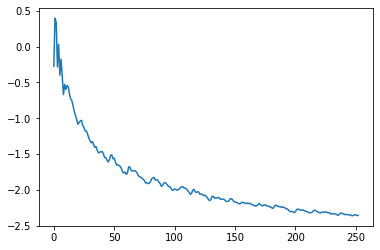

In [52]:
plt.plot(np.log10(loss_track_reg))

plt.show()

In [233]:
%time pred_ratings_inface, loss_inface, loss_track_inface, rank = FW_inface(X_test, FW_objective_function, gamma1 = 0, gamma2 = 0.1, delta = 4, THRES = 10, max_iter = 101, patience = 1e-7, printing=True)

Initial Zk Rank:  1 (200, 400)
Iteration: 1 Loss: 9.097061988681297 Loss diff: 6.1577732530352245 Rank(Z):  1
nuc norm: 1.3763674390989955 alpha 0.5
0 nuc norm: 1.3763674390989955 alpha 0.5
2 nuc norm: 1.9042723174713017 alpha 0.75
4 nuc norm: 2.220713612432838 alpha 0.875
6 nuc norm: 2.059689737369078 alpha 0.8125
8 nuc norm: 1.9811962613242717 alpha 0.78125
10 nuc norm: 2.261705613962723 alpha 0.890625
12 nuc norm: 2.1194846390420667 alpha 0.8359375
14 nuc norm: 2.049798374040288 alpha 0.80859375
16 nuc norm: 2.0153548067842184 alpha 0.794921875
18 nuc norm: 1.9982389857998628 alpha 0.7880859375
20 nuc norm: 2.2707081722508744 alpha 0.89404296875
22 nuc norm: 2.132662873627001 alpha 0.841064453125
24 nuc norm: 2.0649534050443057 alpha 0.8145751953125
26 nuc norm: 2.0314656252521965 alpha 0.80133056640625
28 nuc norm: 2.0148188495037083 alpha 0.794708251953125
30 nuc norm: 2.006520449356213 alpha 0.7913970947265625
32 nuc norm: 2.0023775873014054 alpha 0.7897415161132812
alpha_stop 0.

In [216]:
%time pred_ratings_inface100, loss_inface100, loss_track_inface100, rank100 = FW_inface(X_test, FW_objective_function, gamma1 = 0, gamma2 = 0.1, delta = 100, THRES = 10, max_iter = 101, patience = 1e-7, printing=True)

Initial Zk Rank:  1 (200, 400)
Iteration: 1 Loss: 3920.8075694449426 Loss diff: 997.83975818414 Rank(Z):  1
alpha_stop 0.25
alpha_stop 0.25
alpha_stop 0.25
0.0859375
Iteration: 5 Loss: 9.555740009804753 Loss diff: 0.5942688150210049 Rank(Z):  5
alpha_stop 0.25
0.0859375
alpha_stop 0.25
alpha_stop 0.25
0.0859375
alpha_stop 0.25
0.0859375
alpha_stop 0.25
Iteration: 10 Loss: 13.854325151476896 Loss diff: 130.54076859271893 Rank(Z):  10
alpha_stop 0.25
0.0859375
alpha_stop 0.25
0.0859375
alpha_stop 0.25
alpha_stop 0.25
0.0859375
alpha_stop 0.25
0.0859375
Iteration: 15 Loss: 56.45497325572961 Loss diff: 49.59176466992534 Rank(Z):  15
alpha_stop 0.25
0.0859375
alpha_stop 0.25
0.0859375
alpha_stop 0.25
0.0859375
alpha_stop 0.25
0.0859375
alpha_stop 0.25
0.0859375
Iteration: 20 Loss: 2.99343878114911 Loss diff: 24.38977087574655 Rank(Z):  20
alpha_stop 0.25
0.0859375
alpha_stop 0.25
0.0859375
alpha_stop 0.25
0.0859375
alpha_stop 0.25
0.0859375
alpha_stop 0.25
0.0859375
Iteration: 25 Loss: 19.7

In [237]:
%time pred_ratings_inface1, loss_inface1, loss_track_inface1, rank1 = FW_inface(X_test, FW_objective_function, gamma1 = 0, gamma2 = 0.15, delta = 4, THRES = 10, max_iter = 101, patience = 1e-7, printing=True)

Initial Zk Rank:  1 (200, 400)
Iteration: 1 Loss: 9.0970619886813 Loss diff: 6.1577732530352325 Rank(Z):  1
nuc norm: 1.3763674390989973 alpha 0.5
0 nuc norm: 1.3763674390989973 alpha 0.5
2 nuc norm: 1.904272317471305 alpha 0.75
4 nuc norm: 2.2207136124328417 alpha 0.875
6 nuc norm: 2.386204814226805 alpha 0.9375
8 nuc norm: 2.470344973109713 alpha 0.96875
10 nuc norm: 2.5127228422555663 alpha 0.984375
12 nuc norm: 2.533984210777493 alpha 0.9921875
14 nuc norm: 2.5446324723305627 alpha 0.99609375
16 nuc norm: 2.5499609329782267 alpha 0.998046875
alpha_stop 0.9990234375
0.33560943603515625
nuc norm: 3.4560867992160116 alpha 0.5
0 nuc norm: 3.4560867992160116 alpha 0.5
2 nuc norm: 4.682923444279416 alpha 0.75
4 nuc norm: 4.06871234756412 alpha 0.625
6 nuc norm: 3.7621412328451727 alpha 0.5625
8 nuc norm: 4.836640610958282 alpha 0.78125
10 nuc norm: 4.2988996389026575 alpha 0.671875
12 nuc norm: 4.030367623135312 alpha 0.6171875
14 nuc norm: 3.8962113663598803 alpha 0.58984375
16 nuc norm

C:\Users\cmart\AppData\Local\Temp\ipykernel_19708\1702708772.py:110: RuntimeWarning: divide by zero encountered in true_divide
  inv_s_thin = np.diag(1/s_thin)


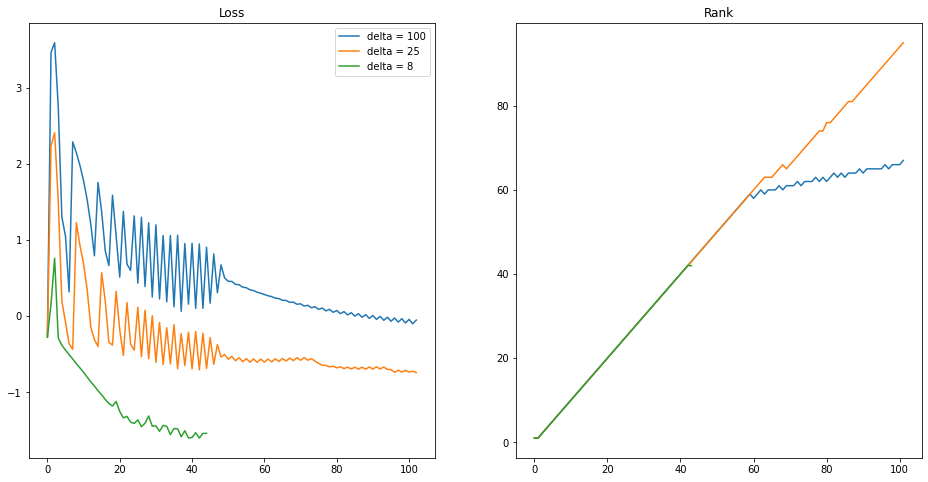

In [168]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,8])
ax1.plot(np.log10(loss_track_inface100), label = 'delta = 100')
ax1.plot(np.log10(loss_track_inface), label = 'delta = 25')
ax1.plot(np.log10(loss_track_inface1), label = 'delta = 8')
ax1.set_title("Loss")
ax1.legend()
ax2.plot(rank100)
ax2.plot(rank)
ax2.plot(rank1)
ax2.set_title("Rank")

plt.show()

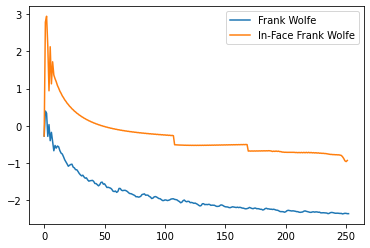

In [92]:
import matplotlib.pyplot as plt

plt.plot(np.log10(loss_track_reg), label = 'Frank Wolfe')
plt.plot(np.log10(loss_track_inface), label = 'In-Face Frank Wolfe')
plt.legend()
plt.show()

# Tuned Model



# Grid Searching

##Delta

In [ ]:
deltas = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000]

for delta in deltas:
  pred_ratings, loss, it = FW_inface(new_data, FW_objective_function, delta = delta, max_iter=201, patience = 0.01, printing = False)
  print('Delta: ' + str(delta) + '    ------     Final Loss: ' + str(loss) + '   at iteration ' + str(it))

Delta: 0.001    ------     Final Loss: 1995299.6906607011   at iteration 2
Delta: 0.01    ------     Final Loss: 1995296.9066038157   at iteration 2
Delta: 0.1    ------     Final Loss: 1995269.065718345   at iteration 2
Delta: 1    ------     Final Loss: 1994990.6592616318   at iteration 4
Delta: 10    ------     Final Loss: 1992207.8429168023   at iteration 19
Delta: 100    ------     Final Loss: 1964496.978598407   at iteration 84
Delta: 1000    ------     Final Loss: 1699162.6623283497   at iteration 201
Delta: 10000    ------     Final Loss: 302150.77467486466   at iteration 64
Delta: 100000    ------     Final Loss: 175474.63085276185   at iteration 70
Delta: 1000000    ------     Final Loss: 146671.28662048402   at iteration 201
Delta: 10000000    ------     Final Loss: 672843.1813172555   at iteration 201
Delta: 100000000    ------     Final Loss: 1757112480.4694064   at iteration 201


In [ ]:
deltas = [250000,
          500000,
          750000,
          1250000,
          1500000,
          2500000,
          5000000,
          7500000]

for delta in deltas:
  pred_ratings, loss, it = FW_inface(new_data, FW_objective_function, delta = delta, max_iter=201, patience = 0.01, printing = False)
  print('Delta: ' + str(delta) + '    ------     Final Loss: ' + str(loss) + '   at iteration ' + str(it))

Delta: 250000    ------     Final Loss: 184966.58801373874   at iteration 142
Delta: 500000    ------     Final Loss: 169552.51866399613   at iteration 201
Delta: 750000    ------     Final Loss: 420615.6132565984   at iteration 201
Delta: 1250000    ------     Final Loss: 216412.31880627264   at iteration 201
Delta: 1500000    ------     Final Loss: 273680.42343568715   at iteration 201
Delta: 2500000    ------     Final Loss: 417712.4612960932   at iteration 201
Delta: 5000000    ------     Final Loss: 571545.4612269908   at iteration 201
Delta: 7500000    ------     Final Loss: 632556.1542439449   at iteration 201


In [ ]:
deltas = [150000,
          300000,
          450000,
          600000,
          900000,
          1200000,
          1500000]

for delta in deltas:
  pred_ratings, loss, it = FW_inface(new_data, FW_objective_function, delta = delta, max_iter=501, patience = 0.01, printing = False)
  print('Delta: ' + str(delta) + '    ------     Final Loss: ' + str(loss) + '   at iteration ' + str(it))

Delta: 150000    ------     Final Loss: 180502.69121015765   at iteration 95
Delta: 300000    ------     Final Loss: 186151.14181067253   at iteration 165
Delta: 450000    ------     Final Loss: 188191.3045520871   at iteration 231
Delta: 600000    ------     Final Loss: 189243.6150128576   at iteration 297
Delta: 900000    ------     Final Loss: 190318.32554160611   at iteration 425
Delta: 1200000    ------     Final Loss: 189679.94593613478   at iteration 501
Delta: 1500000    ------     Final Loss: 149600.4326080835   at iteration 501


In [ ]:
deltas = [1750000,
          2000000,
          2250000]

for delta in deltas:
  pred_ratings, loss, it = FW_inface(new_data, FW_objective_function, delta = delta, max_iter = 1000, patience = 0.001, printing = False)
  print('Delta: ' + str(delta) + '    ------     Final Loss: ' + str(loss) + '   at iteration ' + str(it))

Delta: 1750000    ------     Final Loss: 191384.43819455765   at iteration 786
Delta: 2000000    ------     Final Loss: 191527.2106760225   at iteration 889
Delta: 2250000    ------     Final Loss: 191638.53051798942   at iteration 991


In [ ]:
deltas = [1375000,
          1500000,
          1625000]

for delta in deltas:
  pred_ratings, loss, it = FW_inface(new_data, FW_objective_function, delta = delta, max_iter = 1000, patience = 0.001, printing = False)
  print('Delta: ' + str(delta) + '    ------     Final Loss: ' + str(loss) + '   at iteration ' + str(it))

Delta: 1375000    ------     Final Loss: 191074.29727334835   at iteration 630
Delta: 1500000    ------     Final Loss: 191194.6863524153   at iteration 682
Delta: 1625000    ------     Final Loss: 191296.77299220837   at iteration 734


## Gammas

In [ ]:
gammas = [[0,    0.1],
          [0,    1],
          [0.1,  1],
          [1,    1],
          [1,   10],
          [1,  100],
          [10, 100]]

for gamma1, gamma2 in gammas:
  pred_ratings, loss, it = FW_inface(new_data, FW_objective_function, gamma1 = gamma1, gamma2 = gamma2, delta = 1500000, max_iter = 500, patience = 0.001, printing = False)
  print('Gamma1: ' + str(gamma1) + '   Gamma2: ' + str(gamma2) + '    ------     Final Loss: ' + str(loss) + '   at iteration ' + str(it))

Gamma1: 0   Gamma2: 0.1    ------     Final Loss: 335449.4737096828   at iteration 500
Gamma1: 0   Gamma2: 1    ------     Final Loss: 335449.4737096833   at iteration 500
Gamma1: 0.1   Gamma2: 1    ------     Final Loss: 149460.45148459333   at iteration 500
Gamma1: 1   Gamma2: 1    ------     Final Loss: 149460.451484515   at iteration 500
Gamma1: 1   Gamma2: 10    ------     Final Loss: 335449.47370968235   at iteration 500
Gamma1: 1   Gamma2: 100    ------     Final Loss: 149460.4514845148   at iteration 500
Gamma1: 10   Gamma2: 100    ------     Final Loss: 149460.451484515   at iteration 500


In [ ]:
gammas = [[1,  100],
          [100, 100],
          [0.1,  100],
          [1,    1000]]

for gamma1, gamma2 in gammas:
  pred_ratings, loss, it = FW_inface(new_data, FW_objective_function, gamma1 = gamma1, gamma2 = gamma2, delta = 1500000, max_iter = 500, patience = 0.001, printing = False)
  print('Gamma1: ' + str(gamma1) + '   Gamma2: ' + str(gamma2) + '    ------     Final Loss: ' + str(loss) + '   at iteration ' + str(it))

Gamma1: 1   Gamma2: 100    ------     Final Loss: 149460.45148459318   at iteration 500
Gamma1: 100   Gamma2: 100    ------     Final Loss: 149460.45148451466   at iteration 500
Gamma1: 0.1   Gamma2: 100    ------     Final Loss: 149460.4514845149   at iteration 500
Gamma1: 1   Gamma2: 1000    ------     Final Loss: 335449.4737115356   at iteration 500


In [ ]:
gammas = [[0,  100],
          [0, 1000],
          [0.1,  0.1]]

for gamma1, gamma2 in gammas:
  pred_ratings, loss, it = FW_inface(new_data, FW_objective_function, gamma1 = gamma1, gamma2 = gamma2, delta = 1500000, max_iter = 500, patience = 0.001, printing = False)
  print('Gamma1: ' + str(gamma1) + '   Gamma2: ' + str(gamma2) + '    ------     Final Loss: ' + str(loss) + '   at iteration ' + str(it))

Gamma1: 0   Gamma2: 100    ------     Final Loss: 335449.47371153446   at iteration 500
Gamma1: 0   Gamma2: 1000    ------     Final Loss: 149460.4514845933   at iteration 500
Gamma1: 0.1   Gamma2: 0.1    ------     Final Loss: 149460.45148451495   at iteration 500


## Sub-Chapter